In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# VEST NM 2020
---

## VEST Documentation

### Sources

#### Election Results
Election results from the New Mexico Secretary of State (http://electionresults.sos.state.nm.us/).

#### Shapefiles
Precinct shapefiles from the New Mexico Secretary of State via the University of New Mexico Resource Geographic Information System (https://rgis.unm.edu/rgis6/). All counties are from the NM Voting Precincts 2021 shapefile except for Roosevelt County which is from the NM Voting Precincts 2012 shapefile.

### Processing
The following precincts were merged to reverse splits enacted after the 2020 general election.

Lea: 8/13, 22/37, 23/38, 26/39, 40/41
Lincoln: 3/27/28, 5/26, 7/25, 8/29, 9/24, 11/23
Los Alamos: 5/6, 11/12
Rio Arriba: 38/40, 45/47
Roosevelt: 9/20, 10/21
Valencia: 4/63, 39/64, 44/65, 59/66

Los Alamos County precincts were renumbered and precincts 7/8 were then adjusted to match the 2020 county PDF map. Valencia County precincts 54/55 were adjusted to match the 2020 county precinct viewer.

### Races
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRERTRU - Donald J. Trump (Republican Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREGHAW - Howie Hawkins (Green Party)  
G20PRECTIT - Sheila "Samm" Tittle (Constitution Party)  
G20PRESLAR - Gloria La Riva (Party for Socialism and Liberation)  

G20USSDLUJ - Ben R. Lujan (Democratic Party)  
G20USSRRON - Mark V. Ronchetti (Republican Party)   
G20USSLWAL - Bob Walsh (Libertarian Party)  

G20SSCDBAC - Shannon Bacon (Democratic Party)  
G20SSCRFUL - Ned S. Fuller (Republican Party)  

G20SSCDTHO - David K. Thomson (Democratic Party)  
G20SSCRMOR - Kerry J. Morris (Republican Party)  

G20SACDIVE - Zach Ives (Democratic Party)  
G20SACRJOH - Barbara V. Johnson (Republican Party)  

G20SACDHEN - Shammara H. Henderson (Democratic Party)  
G20SACRLEE - Gertrude Lee (Republican Party)  
G20SACLCUR - Stephen P. Curtis (Libertarian Party)  

G20SACDYOH - Jane B. Yohalem (Democratic Party)  
G20SACRMON - Thomas C. Montoya (Republican Party)  

## Election Result Processing

### Load in VEST file

In [2]:
vest_nm_20 = gp.read_file("./raw-from-source/VEST/nm_2020/nm_2020.shp")

In [3]:
data_columns = [i for i in vest_nm_20.columns if "G20" in i]

### Load Precinct-Level Election Results

Note: The precinct-level election results appear to be obfuscated in cases where a candidate receives fewer than 5 votes, the county-level election results also appear to be obfuscated in such cases, which mainly affects some of the minor presidential candidates.

In [4]:
# Open folder
folder = os.listdir("./raw-from-source/Election_Results/Precinct_Level/")

# Create an empty list to add the overall data
files = []

# Iterate over files in the folder 
for file in folder:
    # Work on precinct-level data files only
    if "Precinct" in file:
        # Create the file path
        election = pd.ExcelFile("./raw-from-source/Election_Results/Precinct_Level/" + file)
        # Set sheet names as counties (each sheet was named after the county data it contains)
        counties = election.sheet_names
        # Create an empty list to add the county data
        df_election = []
        # Iterate over all the counties
        for county in counties: 
            # Import the file
            df = pd.read_excel(election, sheet_name = county, skiprows=[0,1,2,3,4,5])
            # Omit the empty column
            df = df.loc[:, df.columns != df.columns[0]]
            # Add the county column
            df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
            # Add the data to the list
            df_election.append(df)
        # Create each election's final dataframe
        combined_df_election = pd.concat(df_election)
        # Reset index for each election
        combined_df_election.reset_index(drop=True,inplace=True)
        # Add the election results to the overall list
        files.append(combined_df_election)
# Create the final dataframe with all election results
nm_20_precinct = pd.concat(files, axis = 1)

nm_20_precinct

,County,Precinct,BOB WALSH,BEN R LUJAN,MARK V RONCHETTI,County,Precinct,GERTRUDE LEE,SHAMMARA H HENDERSON,STEPHEN P CURTIS,...,JANE B YOHALEM,THOMAS C MONTOYA,County,Precinct,BARBARA V JOHNSON,ZACH IVES,County,Precinct,SHANNON BACON,NED S FULLER
0,Bernalillo,PCT 001,32,493,486,Bernalillo,PCT 001,418,467,85,...,495,475,Bernalillo,PCT 001,466,509,Bernalillo,PCT 001,529,454
1,Bernalillo,PCT 002,21,366,321,Bernalillo,PCT 002,300,345,49,...,368,324,Bernalillo,PCT 002,319,373,Bernalillo,PCT 002,398,300
2,Bernalillo,PCT 003,7,155,199,Bernalillo,PCT 003,172,146,28,...,150,196,Bernalillo,PCT 003,190,156,Bernalillo,PCT 003,159,191
3,Bernalillo,PCT 004,19,336,249,Bernalillo,PCT 004,219,309,52,...,345,234,Bernalillo,PCT 004,226,353,Bernalillo,PCT 004,370,220
4,Bernalillo,PCT 005,9,352,207,Bernalillo,PCT 005,186,343,18,...,342,201,Bernalillo,PCT 005,196,350,Bernalillo,PCT 005,363,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953,Valencia,PRECINCT 59,8,299,439,Valencia,PRECINCT 59,378,293,53,...,286,437,Valencia,PRECINCT 59,428,299,Valencia,PRECINCT 59,327,402
1954,Valencia,PRECINCT 60,9,275,384,Valencia,PRECINCT 60,332,275,38,...,267,375,Valencia,PRECINCT 60,355,290,Valencia,PRECINCT 60,309,346
1955,Valencia,PRECINCT 61,10,176,330,Valencia,PRECINCT 61,277,181,31,...,181,308,Valencia,PRECINCT 61,314,181,Valencia,PRECINCT 61,200,294
1956,Valencia,PRECINCT 62,23,256,315,Valencia,PRECINCT 62,251,272,56,...,267,312,Valencia,PRECINCT 62,310,276,Valencia,PRECINCT 62,312,274


In [5]:
# Rename the columns to match VEST
nm_20_precinct = nm_20_precinct = nm_20_precinct.rename(columns = {'BOB WALSH':"G20USSLWAL",
    'BEN R LUJAN':"G20USSDLUJ",
    'MARK V RONCHETTI':"G20USSRRON",
    'GERTRUDE LEE':"G20SACRLEE",
    'SHAMMARA H HENDERSON':"G20SACDHEN",
    'STEPHEN P CURTIS':"G20SACLCUR",
    'JOSEPH R BIDEN AND KAMALA D HARRIS':"G20PREDBID", 
    'DONALD J TRUMP AND MIKE PENCE':"G20PRERTRU",
    'JO JORGENSEN AND JEREMY "SPIKE" COHEN':"G20PRELJOR",
    'SHEILA "SAMM" TITTLE AND DAVID CARL SANDIGE':"G20PRECTIT",
    'HOWIE HAWKINS AND ANGELA NICOLE WALKER':"G20PREGHAW",
    'GLORIA LA RIVA AND SUNIL FREEMAN':"G20PRESLAR",
    'DAVID K THOMSON':"G20SSCDTHO",
    'KERRY J MORRIS':"G20SSCRMOR",
    'JANE B YOHALEM':"G20SACDYOH",
    'THOMAS C MONTOYA':"G20SACRMON",
    'BARBARA V JOHNSON':"G20SACRJOH",
    'ZACH IVES':"G20SACDIVE",
    'SHANNON BACON':"G20SSCDBAC",
    'NED S FULLER':"G20SSCRFUL"})

# Reorder the columns to match VEST
nm_20_precinct = nm_20_precinct[['County','Precinct','G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PRECTIT', 'G20PRESLAR',
       'G20USSDLUJ', 'G20USSRRON', 'G20USSLWAL', 'G20SSCDBAC', 'G20SSCRFUL',
       'G20SSCDTHO', 'G20SSCRMOR', 'G20SACDIVE', 'G20SACRJOH', 'G20SACDHEN',
       'G20SACRLEE', 'G20SACLCUR', 'G20SACDYOH', 'G20SACRMON']]

# Remove duplicate columns
nm_20_precinct = nm_20_precinct.loc[:,~nm_20_precinct.columns.duplicated()]

# Remove the rows with Total votes
nm_20_precinct = nm_20_precinct[nm_20_precinct["Precinct"]!="TOTALS"]

# Fill n/a values with 0 and * values with 2 (average of the number between 0 and 4)
nm_20_precinct = nm_20_precinct.fillna(0)
nm_20_precinct = nm_20_precinct.replace(to_replace="*", value = 0)

# Display results in alphabetical order of the counties
nm_20_precinct = nm_20_precinct.sort_values(by = ['County', 'Precinct'], ascending = True)

# Change strings to integers (County and Precinct columns remain unchanged)
nm_20_precinct = nm_20_precinct.apply(pd.to_numeric, errors='ignore')

# Deal with the index 
nm_20_precinct.reset_index(drop=True,inplace=True)

### Load County-Level Election Results

In [6]:
# Open folder
folder = os.listdir("./raw-from-source/Election_Results/County_Level/")

# Create an empty list to add the overall data
files = []

# Iterate over files in the folder 
for file in folder:
    # Work on precinct-level data files only
    if "County" in file:
        # Create the file path
        election = pd.ExcelFile("./raw-from-source/Election_Results/County_Level/" + file)
        # Import the file
        df = pd.read_excel(election, skiprows=[0,1,2,3,4,5])
        # Omit the empty column
        df = df.loc[:, df.columns != df.columns[0]]
        # Add the election results to the overall list
        files.append(df)
# Create the final dataframe with all election results
nm_20_county = pd.concat(files, axis = 1)

nm_20_county

,County,GERTRUDE LEE,SHAMMARA H HENDERSON,STEPHEN P CURTIS,County,DAVID K THOMSON,KERRY J MORRIS,County,SHANNON BACON,NED S FULLER,...,County,JANE B YOHALEM,THOMAS C MONTOYA,County,JOSEPH R BIDEN AND KAMALA D HARRIS,DONALD J TRUMP AND MIKE PENCE,"JO JORGENSEN AND JEREMY ""SPIKE"" COHEN","SHEILA ""SAMM"" TITTLE AND DAVID CARL SANDIGE",HOWIE HAWKINS AND ANGELA NICOLE WALKER,GLORIA LA RIVA AND SUNIL FREEMAN
0,Bernalillo,111044,169097,21701,Bernalillo,180438,122885,Bernalillo,187410,117931,...,Bernalillo,174409,126142,Bernalillo,193757,116135,4829,629,1614,626
1,Catron,1543,534,141,Catron,579,1645,Catron,621,1604,...,Catron,558,1654,Catron,595,1698,17,6,7,*
2,Chaves,14113,6061,1475,Chaves,6390,15303,Chaves,6544,15101,...,Chaves,5987,15627,Chaves,6381,15656,268,40,70,28
3,Cibola,3428,4424,696,Cibola,4731,3838,Cibola,5023,3581,...,Cibola,4346,4180,Cibola,4745,3975,99,16,49,19
4,Colfax,2867,2478,442,Colfax,2657,3163,Colfax,2816,3041,...,Colfax,2414,3370,Colfax,2611,3271,87,9,25,13
5,Curry,9551,3907,1096,Curry,4221,10392,Curry,4421,10196,...,Curry,4074,10438,Curry,4307,10444,245,23,53,29
6,De Baca,565,224,49,De Baca,225,621,De Baca,249,589,...,De Baca,215,620,De Baca,231,656,11,*,*,*
7,Dona Ana,30401,43479,6110,Dona Ana,46532,33696,Dona Ana,47078,33181,...,Dona Ana,44461,35446,Dona Ana,47957,32802,1129,178,415,160
8,Eddy,15504,5237,1199,Eddy,5558,16504,Eddy,5667,16258,...,Eddy,5093,16786,Eddy,5424,17454,239,31,44,30
9,Grant,5880,7363,706,Grant,7636,6373,Grant,7851,6168,...,Grant,7260,6672,Grant,7590,6553,159,16,98,19


In [7]:
# Rename the columns to match VEST
nm_20_county = nm_20_county = nm_20_county.rename(columns = {'BOB WALSH':"G20USSLWAL",
    'BEN R LUJAN':"G20USSDLUJ",
    'MARK V RONCHETTI':"G20USSRRON",
    'GERTRUDE LEE':"G20SACRLEE",
    'SHAMMARA H HENDERSON':"G20SACDHEN",
    'STEPHEN P CURTIS':"G20SACLCUR",
    'JOSEPH R BIDEN AND KAMALA D HARRIS':"G20PREDBID", 
    'DONALD J TRUMP AND MIKE PENCE':"G20PRERTRU",
    'JO JORGENSEN AND JEREMY "SPIKE" COHEN':"G20PRELJOR",
    'SHEILA "SAMM" TITTLE AND DAVID CARL SANDIGE':"G20PRECTIT",
    'HOWIE HAWKINS AND ANGELA NICOLE WALKER':"G20PREGHAW",
    'GLORIA LA RIVA AND SUNIL FREEMAN':"G20PRESLAR",
    'DAVID K THOMSON':"G20SSCDTHO",
    'KERRY J MORRIS':"G20SSCRMOR",
    'JANE B YOHALEM':"G20SACDYOH",
    'THOMAS C MONTOYA':"G20SACRMON",
    'BARBARA V JOHNSON':"G20SACRJOH",
    'ZACH IVES':"G20SACDIVE",
    'SHANNON BACON':"G20SSCDBAC",
    'NED S FULLER':"G20SSCRFUL"})

# Reorder the columns to match VEST
nm_20_county = nm_20_county[['County','G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PRECTIT', 'G20PRESLAR',
       'G20USSDLUJ', 'G20USSRRON', 'G20USSLWAL', 'G20SSCDBAC', 'G20SSCRFUL',
       'G20SSCDTHO', 'G20SSCRMOR', 'G20SACDIVE', 'G20SACRJOH', 'G20SACDHEN',
       'G20SACRLEE', 'G20SACLCUR', 'G20SACDYOH', 'G20SACRMON']]

# Remove duplicate columns
nm_20_county = nm_20_county.loc[:,~nm_20_county.columns.duplicated()]

# Remove the rows with Total votes
nm_20_county = nm_20_county[nm_20_county["County"]!="TOTALS"]

# Fill n/a values with 0 and * values with 2 (average of the number between 0 and 4)
nm_20_county = nm_20_county.fillna(0)
nm_20_county = nm_20_county.replace(to_replace="*", value = 0)

# Display results in alphabetical order of the counties
nm_20_county = nm_20_county.sort_values(by = ['County'], ascending = True)

# Change strings to integers (County and Precinct columns remain unchanged)
nm_20_county = nm_20_county.apply(pd.to_numeric, errors='ignore')

# Deal with the index 
nm_20_county.reset_index(drop=True,inplace=True)

## Statewide Totals Check

In [8]:
def statewide_totals_check(partner_df,source_df,column_list):
    """Compares the totals of two election result dataframes at the statewide total level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
 
    Returns:
      Nothing, only prints out an analysis
    """
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [9]:
statewide_totals_check(vest_nm_20,nm_20_precinct,data_columns)

***Statewide Totals Check***
G20PREDBID has a difference of 35 votes
	VEST: 501614 votes
	SOURCES: 501579 votes
G20PRERTRU has a difference of 18 votes
	VEST: 401894 votes
	SOURCES: 401876 votes
G20PRELJOR has a difference of 2599 votes
	VEST: 12585 votes
	SOURCES: 9986 votes
G20PREGHAW has a difference of 3377 votes
	VEST: 4426 votes
	SOURCES: 1049 votes
G20PRECTIT has a difference of 1694 votes
	VEST: 1806 votes
	SOURCES: 112 votes
G20PRESLAR has a difference of 1560 votes
	VEST: 1640 votes
	SOURCES: 80 votes
G20USSDLUJ has a difference of 31 votes
	VEST: 474483 votes
	SOURCES: 474452 votes
G20USSRRON has a difference of 11 votes
	VEST: 418483 votes
	SOURCES: 418472 votes
G20USSLWAL has a difference of 980 votes
	VEST: 24271 votes
	SOURCES: 23291 votes
G20SSCDBAC has a difference of 25 votes
	VEST: 495759 votes
	SOURCES: 495734 votes
G20SSCRFUL has a difference of 15 votes
	VEST: 394595 votes
	SOURCES: 394580 votes
G20SSCDTHO has a difference of 42 votes
	VEST: 480507 votes
	SOURCES:

In [10]:
statewide_totals_check(vest_nm_20,nm_20_county,data_columns)

***Statewide Totals Check***
G20PREDBID is equal 	VEST / RDH: 501614
G20PRERTRU is equal 	VEST / RDH: 401894
G20PRELJOR has a difference of 3 votes
	VEST: 12585 votes
	SOURCES: 12582 votes
G20PREGHAW has a difference of 3 votes
	VEST: 4426 votes
	SOURCES: 4423 votes
G20PRECTIT has a difference of 11 votes
	VEST: 1806 votes
	SOURCES: 1795 votes
G20PRESLAR has a difference of 7 votes
	VEST: 1640 votes
	SOURCES: 1633 votes
G20USSDLUJ is equal 	VEST / RDH: 474483
G20USSRRON is equal 	VEST / RDH: 418483
G20USSLWAL is equal 	VEST / RDH: 24271
G20SSCDBAC is equal 	VEST / RDH: 495759
G20SSCRFUL is equal 	VEST / RDH: 394595
G20SSCDTHO is equal 	VEST / RDH: 480507
G20SSCRMOR is equal 	VEST / RDH: 406791
G20SACDIVE is equal 	VEST / RDH: 464043
G20SACRJOH is equal 	VEST / RDH: 419927
G20SACDHEN is equal 	VEST / RDH: 450566
G20SACRLEE is equal 	VEST / RDH: 370778
G20SACLCUR is equal 	VEST / RDH: 62547
G20SACDYOH is equal 	VEST / RDH: 456645
G20SACRMON is equal 	VEST / RDH: 424153


## Countywide Totals Check

In [11]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
    if (len(diff_counties)>0):
        print()
        print(diff_counties)

In [12]:
# Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="New Mexico"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

# Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

# Create the dictionary
NM_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

# Modify county names in dataframe to match the FIPs file
county_name_changes_dict = {"McKinley":"Mckinley"}
nm_20_precinct["COUNTYFP"] = nm_20_precinct["County"].map(county_name_changes_dict).fillna(nm_20_precinct["County"])

# Use the dictionary to go from a county name to a county FIPS
nm_20_precinct["COUNTYFP"] = nm_20_precinct["COUNTYFP"].map(NM_fips_dict).fillna(nm_20_precinct["COUNTYFP"])

# Check the number of counties - looking for 33
print(len(nm_20_precinct["COUNTYFP"].unique()))

33


#### Add in County FIPs Data to Precinct-Level Election Results

In [13]:
# Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="New Mexico"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

# Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

# Create the dictionary
NM_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

# Modify county names in dataframe to match the FIPs file
county_name_changes_dict = {"McKinley":"Mckinley"}
nm_20_county["COUNTYFP"] = nm_20_county["County"].map(county_name_changes_dict).fillna(nm_20_county["County"])

# Use the dictionary to go from a county name to a county FIPS
nm_20_county["COUNTYFP"] = nm_20_county["COUNTYFP"].map(NM_fips_dict).fillna(nm_20_county["COUNTYFP"])

# Check the number of counties - looking for 33
print(len(nm_20_county["COUNTYFP"].unique()))

33


In [14]:
county_totals_check(vest_nm_20,nm_20_precinct,data_columns,"COUNTYFP",full_print=False)

***Countywide Totals Check***

G20PREDBID contains differences in these counties:
	005 has a difference of 7 votes
		VEST: 6381 votes
		SOURCES: 6374 votes
	015 has a difference of 3 votes
		VEST: 5424 votes
		SOURCES: 5421 votes
	021 has a difference of 2 votes
		VEST: 179 votes
		SOURCES: 177 votes
	025 has a difference of 1 votes
		VEST: 4061 votes
		SOURCES: 4060 votes
	035 has a difference of 4 votes
		VEST: 8485 votes
		SOURCES: 8481 votes
	037 has a difference of 10 votes
		VEST: 1170 votes
		SOURCES: 1160 votes
	039 has a difference of 2 votes
		VEST: 10990 votes
		SOURCES: 10988 votes
	053 has a difference of 3 votes
		VEST: 3722 votes
		SOURCES: 3719 votes
	059 has a difference of 3 votes
		VEST: 383 votes
		SOURCES: 380 votes
G20PRERTRU contains differences in these counties:
	006 has a difference of 4 votes
		VEST: 3975 votes
		SOURCES: 3971 votes
	039 has a difference of 5 votes
		VEST: 5408 votes
		SOURCES: 5403 votes
	049 has a difference of 4 votes
		VEST: 18329 votes
	

		VEST: 19 votes
		SOURCES: 0 votes
	019 has a difference of 5 votes
		VEST: 5 votes
		SOURCES: 0 votes
	021 has a difference of 2 votes
		VEST: 2 votes
		SOURCES: 0 votes
	023 has a difference of 7 votes
		VEST: 7 votes
		SOURCES: 0 votes
	025 has a difference of 24 votes
		VEST: 24 votes
		SOURCES: 0 votes
	027 has a difference of 9 votes
		VEST: 9 votes
		SOURCES: 0 votes
	028 has a difference of 12 votes
		VEST: 12 votes
		SOURCES: 0 votes
	029 has a difference of 9 votes
		VEST: 9 votes
		SOURCES: 0 votes
	031 has a difference of 85 votes
		VEST: 85 votes
		SOURCES: 0 votes
	033 has a difference of 6 votes
		VEST: 6 votes
		SOURCES: 0 votes
	035 has a difference of 30 votes
		VEST: 30 votes
		SOURCES: 0 votes
	037 has a difference of 6 votes
		VEST: 6 votes
		SOURCES: 0 votes
	039 has a difference of 32 votes
		VEST: 32 votes
		SOURCES: 0 votes
	041 has a difference of 7 votes
		VEST: 7 votes
		SOURCES: 0 votes
	043 has a difference of 106 votes
		VEST: 106 votes
		SOURCES: 0 vote

		VEST: 442 votes
		SOURCES: 439 votes
	009 has a difference of 13 votes
		VEST: 1096 votes
		SOURCES: 1083 votes
	011 has a difference of 1 votes
		VEST: 49 votes
		SOURCES: 48 votes
	015 has a difference of 12 votes
		VEST: 1199 votes
		SOURCES: 1187 votes
	017 has a difference of 16 votes
		VEST: 706 votes
		SOURCES: 690 votes
	021 has a difference of 1 votes
		VEST: 32 votes
		SOURCES: 31 votes
	025 has a difference of 7 votes
		VEST: 1184 votes
		SOURCES: 1177 votes
	031 has a difference of 3 votes
		VEST: 2267 votes
		SOURCES: 2264 votes
	033 has a difference of 12 votes
		VEST: 143 votes
		SOURCES: 131 votes
	035 has a difference of 15 votes
		VEST: 1730 votes
		SOURCES: 1715 votes
	037 has a difference of 9 votes
		VEST: 259 votes
		SOURCES: 250 votes
	039 has a difference of 17 votes
		VEST: 1036 votes
		SOURCES: 1019 votes
	041 has a difference of 5 votes
		VEST: 491 votes
		SOURCES: 486 votes
	043 has a difference of 5 votes
		VEST: 5321 votes
		SOURCES: 5316 votes
	047 has 

In [15]:
county_totals_check(vest_nm_20,nm_20_county,data_columns,"COUNTYFP",full_print=False)

***Countywide Totals Check***

G20PREDBID is equal across all counties
G20PRERTRU is equal across all counties
G20PRELJOR contains differences in these counties:
	021 has a difference of 3 votes
		VEST: 3 votes
		SOURCES: 0 votes
G20PREGHAW contains differences in these counties:
	011 has a difference of 1 votes
		VEST: 1 votes
		SOURCES: 0 votes
	059 has a difference of 2 votes
		VEST: 2 votes
		SOURCES: 0 votes
G20PRECTIT contains differences in these counties:
	011 has a difference of 2 votes
		VEST: 2 votes
		SOURCES: 0 votes
	019 has a difference of 4 votes
		VEST: 4 votes
		SOURCES: 0 votes
	021 has a difference of 2 votes
		VEST: 2 votes
		SOURCES: 0 votes
	059 has a difference of 3 votes
		VEST: 3 votes
		SOURCES: 0 votes
G20PRESLAR contains differences in these counties:
	003 has a difference of 3 votes
		VEST: 3 votes
		SOURCES: 0 votes
	021 has a difference of 2 votes
		VEST: 2 votes
		SOURCES: 0 votes
	059 has a difference of 2 votes
		VEST: 2 votes
		SOURCES: 0 votes
G20US

## Precinct Totals Check

In [16]:
nm_20_precinct["Precinct"] = nm_20_precinct["Precinct"].str.replace("PCT","PRECINCT")

In [17]:
vest_nm_20["unique_ID"] = vest_nm_20["COUNTYFP"]+"-"+vest_nm_20["NAME"].str.upper()
nm_20_precinct["unique_ID"] = nm_20_precinct["COUNTYFP"]+"-"+nm_20_precinct["Precinct"].str.upper()

In [18]:
join_attempt_one = pd.merge(vest_nm_20,nm_20_precinct,how="outer",on="unique_ID",validate="1:1",indicator=True)

In [19]:
join_attempt_one["_merge"].value_counts()

both          1510
right_only     415
left_only      407
Name: _merge, dtype: int64

In [20]:
#join_attempt_one[join_attempt_one["_merge"]=="left_only"].to_csv("./vest_only.csv")
#join_attempt_one[join_attempt_one["_merge"]=="right_only"].to_csv("./source_only.csv")

In [22]:
source_vest_id_changes_dict = {'007-001': '007-PRECINCT 001', '007-002': '007-PRECINCT 002', '007-003': '007-PRECINCT 003', '007-004': '007-PRECINCT 004', '007-005': '007-PRECINCT 005', '007-007': '007-PRECINCT 007', '007-008': '007-PRECINCT 008', '007-009': '007-PRECINCT 009', '007-010': '007-PRECINCT 010', '007-011': '007-PRECINCT 011', '007-012': '007-PRECINCT 012', '007-013': '007-PRECINCT 013', '007-014': '007-PRECINCT 014', '007-015': '007-PRECINCT 015', '007-016': '007-PRECINCT 016', '007-017': '007-PRECINCT 017', '007-018': '007-PRECINCT 018', '007-019': '007-PRECINCT 019', '007-020': '007-PRECINCT 020', '007-021': '007-PRECINCT 021', '007-022': '007-PRECINCT 022', '011-PRECINCT 1': '011-PRECINCT 001', '011-PRECINCT 2': '011-PRECINCT 002', '011-PRECINCT 3': '011-PRECINCT 003', '011-PRECINCT 4': '011-PRECINCT 004', '015-PRECINCT 01': '015-PRECINCT 001', '015-PRECINCT 02': '015-PRECINCT 002', '015-PRECINCT 03': '015-PRECINCT 003', '015-PRECINCT 04': '015-PRECINCT 004', '015-PRECINCT 05': '015-PRECINCT 005', '015-PRECINCT 06': '015-PRECINCT 006', '015-PRECINCT 07': '015-PRECINCT 007', '015-PRECINCT 08': '015-PRECINCT 008', '015-PRECINCT 09': '015-PRECINCT 009', '015-PRECINCT 10': '015-PRECINCT 010', '015-PRECINCT 11': '015-PRECINCT 011', '015-PRECINCT 12': '015-PRECINCT 012', '015-PRECINCT 13': '015-PRECINCT 013', '015-PRECINCT 14': '015-PRECINCT 014', '015-PRECINCT 15': '015-PRECINCT 015', '015-PRECINCT 16': '015-PRECINCT 016', '015-PRECINCT 17': '015-PRECINCT 017', '015-PRECINCT 18': '015-PRECINCT 018', '015-PRECINCT 19': '015-PRECINCT 019', '015-PRECINCT 20': '015-PRECINCT 020', '015-PRECINCT 21': '015-PRECINCT 021', '015-PRECINCT 23': '015-PRECINCT 023', '015-PRECINCT 25': '015-PRECINCT 025', '015-PRECINCT 26': '015-PRECINCT 026', '015-PRECINCT 27': '015-PRECINCT 027', '015-PRECINCT 28': '015-PRECINCT 028', '015-PRECINCT 29': '015-PRECINCT 029', '015-PRECINCT 30': '015-PRECINCT 030', '015-PRECINCT 32': '015-PRECINCT 032', '015-PRECINCT 33': '015-PRECINCT 033', '015-PRECINCT 34': '015-PRECINCT 034', '015-PRECINCT 35': '015-PRECINCT 035', '015-PRECINCT 36': '015-PRECINCT 036', '015-PRECINCT 37': '015-PRECINCT 037', '015-PRECINCT 38': '015-PRECINCT 038', '015-PRECINCT 39': '015-PRECINCT 039', '015-PRECINCT 40': '015-PRECINCT 040', '015-PRECINCT 41': '015-PRECINCT 041', '015-PRECINCT 42': '015-PRECINCT 042', '015-PRECINCT 44': '015-PRECINCT 044', '015-PRECINCT 45': '015-PRECINCT 045', '019-PRECINCT 1': '019-PRECINCT 001', '019-PRECINCT 2': '019-PRECINCT 002', '019-PRECINCT 3': '019-PRECINCT 003', '019-PRECINCT 4': '019-PRECINCT 004', '019-PRECINCT 5': '019-PRECINCT 005', '023-PRECINCT 1 - LORDSBURG/WEST': '023-PRECINCT 001', '023-PRECINCT 2 - LORDSBURGE/CENTRAL': '023-PRECINCT 002', '023-PRECINCT 3 - LORDSBURG/EAST': '023-PRECINCT 003', '023-PRECINCT 4 - VIRDEN': '023-PRECINCT 004', '023-PRECINCT 5 - RODEO': '023-PRECINCT 005', '023-PRECINCT 6 - ANIMAS': '023-PRECINCT 006', '028-PRECINCT 01': '028-PRECINCT 001', '028-PRECINCT 02': '028-PRECINCT 002', '028-PRECINCT 03': '028-PRECINCT 003', '028-PRECINCT 04': '028-PRECINCT 004', '028-PRECINCT 05': '028-PRECINCT 005', '028-PRECINCT 06': '028-PRECINCT 006', '028-PRECINCT 07': '028-PRECINCT 007', '028-PRECINCT 08': '028-PRECINCT 008', '028-PRECINCT 09': '028-PRECINCT 009', '028-PRECINCT 10': '028-PRECINCT 010', '028-PRECINCT 11': '028-PRECINCT 011', '028-PRECINCT 12': '028-PRECINCT 012', '028-PRECINCT 13': '028-PRECINCT 013', '028-PRECINCT 14': '028-PRECINCT 014', '028-PRECINCT 15': '028-PRECINCT 015', '028-PRECINCT 16': '028-PRECINCT 016', '028-PRECINCT 17': '028-PRECINCT 017', '028-PRECINCT 18': '028-PRECINCT 018', '028-PRECINCT 19': '028-PRECINCT 019', '028-PRECINCT 20': '028-PRECINCT 020', '028-PRECINCT 21': '028-PRECINCT 021', '031-PRECINCT 01': '031-PRECINCT 001', '031-PRECINCT 02': '031-PRECINCT 002', '031-PRECINCT 03': '031-PRECINCT 003', '031-PRECINCT 04': '031-PRECINCT 004', '031-PRECINCT 05': '031-PRECINCT 005', '031-PRECINCT 06': '031-PRECINCT 006', '031-PRECINCT 07': '031-PRECINCT 007', '031-PRECINCT 08': '031-PRECINCT 008', '031-PRECINCT 09': '031-PRECINCT 009', '031-PRECINCT 10': '031-PRECINCT 010', '031-PRECINCT 11': '031-PRECINCT 011', '031-PRECINCT 12': '031-PRECINCT 012', '031-PRECINCT 13': '031-PRECINCT 013', '031-PRECINCT 14': '031-PRECINCT 014', '031-PRECINCT 15': '031-PRECINCT 015', '031-PRECINCT 16': '031-PRECINCT 016', '031-PRECINCT 17': '031-PRECINCT 017', '031-PRECINCT 18': '031-PRECINCT 018', '031-PRECINCT 19': '031-PRECINCT 019', '031-PRECINCT 20': '031-PRECINCT 020', '031-PRECINCT 21': '031-PRECINCT 021', '031-PRECINCT 22': '031-PRECINCT 022', '031-PRECINCT 23': '031-PRECINCT 023', '031-PRECINCT 24': '031-PRECINCT 024', '031-PRECINCT 25': '031-PRECINCT 025', '031-PRECINCT 26': '031-PRECINCT 026', '031-PRECINCT 27': '031-PRECINCT 027', '031-PRECINCT 28': '031-PRECINCT 028', '031-PRECINCT 29': '031-PRECINCT 029', '031-PRECINCT 30': '031-PRECINCT 030', '031-PRECINCT 31': '031-PRECINCT 031', '031-PRECINCT 32': '031-PRECINCT 032', '031-PRECINCT 33': '031-PRECINCT 033', '031-PRECINCT 34': '031-PRECINCT 034', '031-PRECINCT 35': '031-PRECINCT 035', '031-PRECINCT 36': '031-PRECINCT 036', '031-PRECINCT 37': '031-PRECINCT 037', '031-PRECINCT 38': '031-PRECINCT 038', '031-PRECINCT 39': '031-PRECINCT 039', '031-PRECINCT 40': '031-PRECINCT 040', '031-PRECINCT 41': '031-PRECINCT 041', '031-PRECINCT 42': '031-PRECINCT 042', '031-PRECINCT 43': '031-PRECINCT 043', '031-PRECINCT 44': '031-PRECINCT 044', '031-PRECINCT 45': '031-PRECINCT 045', '031-PRECINCT 46': '031-PRECINCT 046', '031-PRECINCT 47': '031-PRECINCT 047', '031-PRECINCT 48': '031-PRECINCT 048', '031-PRECINCT 49': '031-PRECINCT 049', '031-PRECINCT 50': '031-PRECINCT 050', '031-PRECINCT 51': '031-PRECINCT 051', '031-PRECINCT 52': '031-PRECINCT 052', '031-PRECINCT 53': '031-PRECINCT 053', '031-PRECINCT 54': '031-PRECINCT 054', '031-PRECINCT 55': '031-PRECINCT 055', '031-PRECINCT 56': '031-PRECINCT 056', '031-PRECINCT 57': '031-PRECINCT 057', '031-PRECINCT 58': '031-PRECINCT 058', '031-PRECINCT 59': '031-PRECINCT 059', '031-PRECINCT 60': '031-PRECINCT 060', '031-PRECINCT 61': '031-PRECINCT 061', '031-PRECINCT 62': '031-PRECINCT 062', '031-PRECINCT 63': '031-PRECINCT 063', '031-PRECINCT 64': '031-PRECINCT 064', '031-PRECINCT 65': '031-PRECINCT 065', '035-PRECINCT 01': '035-PRECINCT 001', '035-PRECINCT 02': '035-PRECINCT 002', '035-PRECINCT 03': '035-PRECINCT 003', '035-PRECINCT 04': '035-PRECINCT 004', '035-PRECINCT 05': '035-PRECINCT 005', '035-PRECINCT 06': '035-PRECINCT 006', '035-PRECINCT 07': '035-PRECINCT 007', '035-PRECINCT 08': '035-PRECINCT 008', '035-PRECINCT 09': '035-PRECINCT 009', '035-PRECINCT 10': '035-PRECINCT 010', '035-PRECINCT 11': '035-PRECINCT 011', '035-PRECINCT 12': '035-PRECINCT 012', '035-PRECINCT 13': '035-PRECINCT 013', '035-PRECINCT 14': '035-PRECINCT 014', '035-PRECINCT 15': '035-PRECINCT 015', '035-PRECINCT 16': '035-PRECINCT 016', '035-PRECINCT 17': '035-PRECINCT 017', '035-PRECINCT 18': '035-PRECINCT 018', '035-PRECINCT 19': '035-PRECINCT 019', '035-PRECINCT 20': '035-PRECINCT 020', '035-PRECINCT 21': '035-PRECINCT 021', '035-PRECINCT 22': '035-PRECINCT 022', '035-PRECINCT 23': '035-PRECINCT 023', '035-PRECINCT 24': '035-PRECINCT 024', '035-PRECINCT 25': '035-PRECINCT 025', '035-PRECINCT 26': '035-PRECINCT 026', '035-PRECINCT 27': '035-PRECINCT 027', '035-PRECINCT 28': '035-PRECINCT 028', '035-PRECINCT 29': '035-PRECINCT 029', '035-PRECINCT 30': '035-PRECINCT 030', '035-PRECINCT 31': '035-PRECINCT 031', '035-PRECINCT 32': '035-PRECINCT 032', '035-PRECINCT 33': '035-PRECINCT 033', '035-PRECINCT 34': '035-PRECINCT 034', '035-PRECINCT 35': '035-PRECINCT 035', '035-PRECINCT 36': '035-PRECINCT 036', '035-PRECINCT 37': '035-PRECINCT 037', '035-PRECINCT 38': '035-PRECINCT 038', '035-PRECINCT 39': '035-PRECINCT 039', '035-PRECINCT 40': '035-PRECINCT 040', '035-PRECINCT 41': '035-PRECINCT 041', '035-PRECINCT 42': '035-PRECINCT 042', '035-PRECINCT 43': '035-PRECINCT 043', '035-PRECINCT 44': '035-PRECINCT 044', '035-PRECINCT 45': '035-PRECINCT 045', '035-PRECINCT 46': '035-PRECINCT 046', '035-PRECINCT 47': '035-PRECINCT 047', '035-PRECINCT 48': '035-PRECINCT 048', '035-PRECINCT 49': '035-PRECINCT 049', '035-PRECINCT 50': '035-PRECINCT 050', '035-PRECINCT 51': '035-PRECINCT 051', '035-PRECINCT 52': '035-PRECINCT 052', '035-PRECINCT 53': '035-PRECINCT 053', '035-PRECINCT 54': '035-PRECINCT 054', '035-PRECINCT 55': '035-PRECINCT 055', '035-PRECINCT 56': '035-PRECINCT 056', '035-PRECINCT 57': '035-PRECINCT 057', '035-PRECINCT 58': '035-PRECINCT 058', '035-PRECINCT 59': '035-PRECINCT 059', '039-PREC 001': '039-PRECINCT 001', '039-PREC 002': '039-PRECINCT 002', '039-PREC 003': '039-PRECINCT 003', '039-PREC 004': '039-PRECINCT 004', '039-PREC 005': '039-PRECINCT 005', '039-PREC 010': '039-PRECINCT 010', '039-PREC 011': '039-PRECINCT 011', '039-PREC 012': '039-PRECINCT 012', '039-PREC 013': '039-PRECINCT 013', '039-PREC 014': '039-PRECINCT 014', '039-PREC 021': '039-PRECINCT 021', '039-PREC 022': '039-PRECINCT 022', '039-PREC 023': '039-PRECINCT 023', '039-PREC 024': '039-PRECINCT 024', '039-PREC 025': '039-PRECINCT 025', '039-PREC 026': '039-PRECINCT 026', '039-PREC 027': '039-PRECINCT 027', '039-PREC 028': '039-PRECINCT 028', '039-PREC 035': '039-PRECINCT 035', '039-PREC 036': '039-PRECINCT 036', '039-PREC 037': '039-PRECINCT 037', '039-PREC 038': '039-PRECINCT 038', '039-PREC 039': '039-PRECINCT 039', '039-PREC 046': '039-PRECINCT 046', '039-PREC 047': '039-PRECINCT 047', '039-PREC 048': '039-PRECINCT 048', '039-PREC 049': '039-PRECINCT 049', '039-PREC 056': '039-PRECINCT 056', '039-PREC 057': '039-PRECINCT 057', '039-PREC 058': '039-PRECINCT 058', '039-PREC 059': '039-PRECINCT 059', '039-PREC 060': '039-PRECINCT 060', '039-PREC 061': '039-PRECINCT 061', '039-PREC 062': '039-PRECINCT 062', '039-PREC 063': '039-PRECINCT 063', '039-PREC 064': '039-PRECINCT 064', '039-PREC 065': '039-PRECINCT 065', '039-PREC 066': '039-PRECINCT 066', '039-PREC 067': '039-PRECINCT 067', '039-PREC 068': '039-PRECINCT 068', '039-PREC 069': '039-PRECINCT 069', '039-PREC 070': '039-PRECINCT 070', '039-PREC 071': '039-PRECINCT 071', '039-PREC 072': '039-PRECINCT 072', '039-PREC 073': '039-PRECINCT 073', '039-PREC 074': '039-PRECINCT 074', '045-PRECINCT 01': '045-PRECINCT 001', '045-PRECINCT 02': '045-PRECINCT 002', '045-PRECINCT 03': '045-PRECINCT 003', '045-PRECINCT 04': '045-PRECINCT 004', '045-PRECINCT 05': '045-PRECINCT 005', '045-PRECINCT 06': '045-PRECINCT 006', '045-PRECINCT 07': '045-PRECINCT 007', '045-PRECINCT 08': '045-PRECINCT 008', '045-PRECINCT 09': '045-PRECINCT 009', '045-PRECINCT 10': '045-PRECINCT 010', '045-PRECINCT 11': '045-PRECINCT 011', '045-PRECINCT 12': '045-PRECINCT 012', '045-PRECINCT 13': '045-PRECINCT 013', '045-PRECINCT 14': '045-PRECINCT 014', '045-PRECINCT 15': '045-PRECINCT 015', '045-PRECINCT 16': '045-PRECINCT 016', '045-PRECINCT 17': '045-PRECINCT 017', '045-PRECINCT 18': '045-PRECINCT 018', '045-PRECINCT 19': '045-PRECINCT 019', '045-PRECINCT 20': '045-PRECINCT 020', '045-PRECINCT 21': '045-PRECINCT 021', '045-PRECINCT 22': '045-PRECINCT 022', '045-PRECINCT 23': '045-PRECINCT 023', '045-PRECINCT 24': '045-PRECINCT 024', '045-PRECINCT 25': '045-PRECINCT 025', '045-PRECINCT 26': '045-PRECINCT 026', '045-PRECINCT 27': '045-PRECINCT 027', '045-PRECINCT 28': '045-PRECINCT 028', '045-PRECINCT 29': '045-PRECINCT 029', '045-PRECINCT 30': '045-PRECINCT 030', '045-PRECINCT 31': '045-PRECINCT 031', '045-PRECINCT 32': '045-PRECINCT 032', '045-PRECINCT 33': '045-PRECINCT 033', '045-PRECINCT 34': '045-PRECINCT 034', '045-PRECINCT 35': '045-PRECINCT 035', '045-PRECINCT 36': '045-PRECINCT 036', '045-PRECINCT 37': '045-PRECINCT 037', '045-PRECINCT 38': '045-PRECINCT 038', '045-PRECINCT 39': '045-PRECINCT 039', '045-PRECINCT 40': '045-PRECINCT 040', '045-PRECINCT 41': '045-PRECINCT 041', '045-PRECINCT 42': '045-PRECINCT 042', '045-PRECINCT 43': '045-PRECINCT 043', '045-PRECINCT 44': '045-PRECINCT 044', '045-PRECINCT 45': '045-PRECINCT 045', '045-PRECINCT 46': '045-PRECINCT 046', '045-PRECINCT 47': '045-PRECINCT 047', '045-PRECINCT 48': '045-PRECINCT 048', '045-PRECINCT 49': '045-PRECINCT 049', '045-PRECINCT 50': '045-PRECINCT 050', '045-PRECINCT 51': '045-PRECINCT 051', '045-PRECINCT 52': '045-PRECINCT 052', '045-PRECINCT 53': '045-PRECINCT 053', '045-PRECINCT 54': '045-PRECINCT 054', '045-PRECINCT 55': '045-PRECINCT 055', '045-PRECINCT 56': '045-PRECINCT 056', '045-PRECINCT 57': '045-PRECINCT 057', '045-PRECINCT 58': '045-PRECINCT 058', '045-PRECINCT 59': '045-PRECINCT 059', '045-PRECINCT 60': '045-PRECINCT 060', '045-PRECINCT 61': '045-PRECINCT 061', '045-PRECINCT 62': '045-PRECINCT 062', '045-PRECINCT 63': '045-PRECINCT 063', '045-PRECINCT 64': '045-PRECINCT 064', '045-PRECINCT 65': '045-PRECINCT 065', '045-PRECINCT 66': '045-PRECINCT 066', '045-PRECINCT 67': '045-PRECINCT 067', '045-PRECINCT 68': '045-PRECINCT 068', '045-PRECINCT 69': '045-PRECINCT 069', '045-PRECINCT 70': '045-PRECINCT 070', '045-PRECINCT 71': '045-PRECINCT 071', '045-PRECINCT 72': '045-PRECINCT 072', '045-PRECINCT 73': '045-PRECINCT 073', '045-PRECINCT 74': '045-PRECINCT 074', '045-PRECINCT 75': '045-PRECINCT 075', '045-PRECINCT 76': '045-PRECINCT 076', '045-PRECINCT 77': '045-PRECINCT 077', '061-PRECINCT 01': '061-PRECINCT 001', '061-PRECINCT 02': '061-PRECINCT 002', '061-PRECINCT 03': '061-PRECINCT 003', '061-PRECINCT 04': '061-PRECINCT 004', '061-PRECINCT 05': '061-PRECINCT 005', '061-PRECINCT 06': '061-PRECINCT 006', '061-PRECINCT 07': '061-PRECINCT 007', '061-PRECINCT 08': '061-PRECINCT 008', '061-PRECINCT 09': '061-PRECINCT 009', '061-PRECINCT 10': '061-PRECINCT 010', '061-PRECINCT 11': '061-PRECINCT 011', '061-PRECINCT 12': '061-PRECINCT 012', '061-PRECINCT 13': '061-PRECINCT 013', '061-PRECINCT 14': '061-PRECINCT 014', '061-PRECINCT 15': '061-PRECINCT 015', '061-PRECINCT 16': '061-PRECINCT 016', '061-PRECINCT 17': '061-PRECINCT 017', '061-PRECINCT 18': '061-PRECINCT 018', '061-PRECINCT 19': '061-PRECINCT 019', '061-PRECINCT 20': '061-PRECINCT 020', '061-PRECINCT 21': '061-PRECINCT 021', '061-PRECINCT 22': '061-PRECINCT 022', '061-PRECINCT 23': '061-PRECINCT 023', '061-PRECINCT 24': '061-PRECINCT 024', '061-PRECINCT 25': '061-PRECINCT 025', '061-PRECINCT 26': '061-PRECINCT 026', '061-PRECINCT 27': '061-PRECINCT 027', '061-PRECINCT 28': '061-PRECINCT 028', '061-PRECINCT 29': '061-PRECINCT 029', '061-PRECINCT 30': '061-PRECINCT 030', '061-PRECINCT 31': '061-PRECINCT 031', '061-PRECINCT 32': '061-PRECINCT 032', '061-PRECINCT 33': '061-PRECINCT 033', '061-PRECINCT 34': '061-PRECINCT 034', '061-PRECINCT 35': '061-PRECINCT 035', '061-PRECINCT 36': '061-PRECINCT 036', '061-PRECINCT 37': '061-PRECINCT 037', '061-PRECINCT 38': '061-PRECINCT 038', '061-PRECINCT 39': '061-PRECINCT 039', '061-PRECINCT 40': '061-PRECINCT 040', '061-PRECINCT 41': '061-PRECINCT 041', '061-PRECINCT 42': '061-PRECINCT 042', '061-PRECINCT 43': '061-PRECINCT 043', '061-PRECINCT 44': '061-PRECINCT 044', '061-PRECINCT 45': '061-PRECINCT 045', '061-PRECINCT 46': '061-PRECINCT 046', '061-PRECINCT 47': '061-PRECINCT 047', '061-PRECINCT 48': '061-PRECINCT 048', '061-PRECINCT 49': '061-PRECINCT 049', '061-PRECINCT 50': '061-PRECINCT 050', '061-PRECINCT 51': '061-PRECINCT 051', '061-PRECINCT 52': '061-PRECINCT 052', '061-PRECINCT 53': '061-PRECINCT 053', '061-PRECINCT 54': '061-PRECINCT 054', '061-PRECINCT 55': '061-PRECINCT 055', '061-PRECINCT 56': '061-PRECINCT 056', '061-PRECINCT 57': '061-PRECINCT 057', '061-PRECINCT 58': '061-PRECINCT 058', '061-PRECINCT 59': '061-PRECINCT 059', '061-PRECINCT 60': '061-PRECINCT 060', '061-PRECINCT 61': '061-PRECINCT 061', '061-PRECINCT 62': '061-PRECINCT 062'}

In [23]:
nm_20_precinct["unique_ID"] = nm_20_precinct["unique_ID"].map(source_vest_id_changes_dict).fillna(nm_20_precinct["unique_ID"])

In [24]:
join_attempt_two = pd.merge(vest_nm_20,nm_20_precinct,how="outer",on="unique_ID",validate="1:1",indicator=True)
join_attempt_two["_merge"].value_counts()

both          1917
right_only       8
left_only        0
Name: _merge, dtype: int64

In [25]:
for i in data_columns:
    right_var = i+"_y"
    print(right_var)
    print(sum(join_attempt_two[join_attempt_two["_merge"]=="right_only"][right_var]))

G20PREDBID_y
0
G20PRERTRU_y
0
G20PRELJOR_y
0
G20PREGHAW_y
0
G20PRECTIT_y
0
G20PRESLAR_y
0
G20USSDLUJ_y
0
G20USSRRON_y
0
G20USSLWAL_y
0
G20SSCDBAC_y
0
G20SSCRFUL_y
0
G20SSCDTHO_y
0
G20SSCRMOR_y
0
G20SACDIVE_y
0
G20SACRJOH_y
0
G20SACDHEN_y
0
G20SACRLEE_y
0
G20SACLCUR_y
0
G20SACDYOH_y
0
G20SACRMON_y
0


In [26]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    """Checks a merged dataframe with two election results at the precinct level

    Args:
      merged_df: DataFrame with one set of election results joined to another
      column_list: List of races that there are votes for
      vest_on_left: Boolean specifying whether VEST data is on the left side of merged_df
      name_col: String of the column name to refer to precincts when a difference occurs
      print_level: Integer that specifies how large the vote difference in a precinct must be to be printed

    Returns:
      Nothing, only prints out an analysis
    """
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [27]:
precinct_votes_check(join_attempt_two[join_attempt_two["_merge"]=="both"],data_columns,True,"unique_ID",print_level=0)

G20PREGHAW ........................................................001-PRECINCT 001 (V) ....3  (S)....0 (D):    3
G20PRECTIT ........................................................001-PRECINCT 001 (V) ....4  (S)....0 (D):    4
G20PREGHAW ........................................................001-PRECINCT 002 (V) ....3  (S)....0 (D):    3
G20PRELJOR ........................................................001-PRECINCT 003 (V) ....2  (S)....0 (D):    2
G20PREGHAW ........................................................001-PRECINCT 003 (V) ....2  (S)....0 (D):    2
G20PRECTIT ........................................................001-PRECINCT 003 (V) ....2  (S)....0 (D):    2
G20PREGHAW ........................................................001-PRECINCT 004 (V) ....2  (S)....0 (D):    2
G20PRECTIT ........................................................001-PRECINCT 004 (V) ....2  (S)....0 (D):    2
G20PRESLAR ........................................................001-PRECINCT 004 (V) 

G20PRESLAR ........................................................001-PRECINCT 131 (V) ....1  (S)....0 (D):    1
G20PREGHAW ........................................................001-PRECINCT 132 (V) ....5  (S)....0 (D):    5
G20PRECTIT ........................................................001-PRECINCT 132 (V) ....2  (S)....0 (D):    2
G20PRELJOR ........................................................001-PRECINCT 133 (V) ....2  (S)....0 (D):    2
G20PREGHAW ........................................................001-PRECINCT 133 (V) ....3  (S)....0 (D):    3
G20PREGHAW ........................................................001-PRECINCT 134 (V) ....3  (S)....0 (D):    3
G20PRELJOR ........................................................001-PRECINCT 135 (V) ....3  (S)....0 (D):    3
G20PREGHAW ........................................................001-PRECINCT 135 (V) ....3  (S)....0 (D):    3
G20PRECTIT ........................................................001-PRECINCT 135 (V) 

G20PRELJOR ........................................................001-PRECINCT 267 (V) ....4  (S)....0 (D):    4
G20PREGHAW ........................................................001-PRECINCT 267 (V) ....2  (S)....0 (D):    2
G20PRESLAR ........................................................001-PRECINCT 267 (V) ....1  (S)....0 (D):    1
G20PRELJOR ........................................................001-PRECINCT 268 (V) ....2  (S)....0 (D):    2
G20PRECTIT ........................................................001-PRECINCT 268 (V) ....1  (S)....0 (D):    1
G20PRESLAR ........................................................001-PRECINCT 268 (V) ....1  (S)....0 (D):    1
G20USSLWAL ........................................................001-PRECINCT 268 (V) ....5  (S)....0 (D):    5
G20PRECTIT ........................................................001-PRECINCT 269 (V) ....2  (S)....0 (D):    2
G20PRELJOR ........................................................001-PRECINCT 270 (V) 

G20PREGHAW ........................................................001-PRECINCT 412 (V) ....2  (S)....0 (D):    2
G20PRESLAR ........................................................001-PRECINCT 412 (V) ....2  (S)....0 (D):    2
G20PRECTIT ........................................................001-PRECINCT 413 (V) ....2  (S)....0 (D):    2
G20PRESLAR ........................................................001-PRECINCT 413 (V) ....2  (S)....0 (D):    2
G20PRELJOR ........................................................001-PRECINCT 414 (V) ....4  (S)....0 (D):    4
G20USSLWAL ........................................................001-PRECINCT 414 (V) ....4  (S)....0 (D):    4
G20PRELJOR ........................................................001-PRECINCT 415 (V) ....3  (S)....0 (D):    3
G20PREGHAW ........................................................001-PRECINCT 415 (V) ....3  (S)....0 (D):    3
G20PRECTIT ........................................................001-PRECINCT 415 (V) 

G20PRECTIT ........................................................001-PRECINCT 570 (V) ....1  (S)....0 (D):    1
G20PRESLAR ........................................................001-PRECINCT 570 (V) ....1  (S)....0 (D):    1
G20USSLWAL ........................................................001-PRECINCT 570 (V) ....5  (S)....0 (D):    5
G20PREGHAW ........................................................001-PRECINCT 571 (V) ....1  (S)....0 (D):    1
G20PRELJOR ........................................................001-PRECINCT 572 (V) ....4  (S)....0 (D):    4
G20PREGHAW ........................................................001-PRECINCT 572 (V) ....3  (S)....0 (D):    3
G20PRECTIT ........................................................001-PRECINCT 572 (V) ....1  (S)....0 (D):    1
G20PRESLAR ........................................................001-PRECINCT 572 (V) ....1  (S)....0 (D):    1
G20PRECTIT ........................................................001-PRECINCT 573 (V) 

G20PRESLAR ........................................................006-PRECINCT 015 (V) ....1  (S)....0 (D):    1
G20USSLWAL ........................................................006-PRECINCT 015 (V) ....5  (S)....0 (D):    5
G20PRELJOR ........................................................006-PRECINCT 016 (V) ....2  (S)....0 (D):    2
G20PREGHAW ........................................................006-PRECINCT 016 (V) ....2  (S)....0 (D):    2
G20USSLWAL ........................................................006-PRECINCT 016 (V) ....3  (S)....0 (D):    3
G20PRELJOR ........................................................006-PRECINCT 017 (V) ....5  (S)....0 (D):    5
G20PRESLAR ........................................................006-PRECINCT 017 (V) ....3  (S)....0 (D):    3
G20PREGHAW ........................................................006-PRECINCT 018 (V) ....1  (S)....0 (D):    1
G20PRECTIT ........................................................006-PRECINCT 018 (V) 

G20PRECTIT ........................................................009-PRECINCT 032 (V) ....1  (S)....0 (D):    1
G20PRELJOR ........................................................009-PRECINCT 033 (V) ....5  (S)....0 (D):    5
G20PRECTIT ........................................................009-PRECINCT 033 (V) ....1  (S)....0 (D):    1
G20USSLWAL ........................................................009-PRECINCT 034 (V) ....1  (S)....0 (D):    1
G20SACLCUR ........................................................009-PRECINCT 034 (V) ....4  (S)....0 (D):    4
G20PREGHAW ........................................................009-PRECINCT 035 (V) ....1  (S)....0 (D):    1
G20PRECTIT ........................................................009-PRECINCT 035 (V) ....1  (S)....0 (D):    1
G20PRELJOR ........................................................009-PRECINCT 036 (V) ....2  (S)....0 (D):    2
G20PREGHAW ........................................................009-PRECINCT 036 (V) 

G20PRESLAR ........................................................013-PRECINCT 117 (V) ....3  (S)....0 (D):    3
G20PREGHAW ........................................................013-PRECINCT 118 (V) ....4  (S)....0 (D):    4
G20PRECTIT ........................................................013-PRECINCT 118 (V) ....2  (S)....0 (D):    2
G20PREGHAW ........................................................013-PRECINCT 119 (V) ....5  (S)....0 (D):    5
G20PRECTIT ........................................................013-PRECINCT 119 (V) ....3  (S)....0 (D):    3
G20PRELJOR ........................................................013-PRECINCT 120 (V) ....3  (S)....0 (D):    3
G20PREGHAW ........................................................013-PRECINCT 120 (V) ....1  (S)....0 (D):    1
G20PRESLAR ........................................................013-PRECINCT 120 (V) ....1  (S)....0 (D):    1
G20PRELJOR ........................................................013-PRECINCT 121 (V) 

G20PRELJOR ........................................................017-PRECINCT 018 (V) ....3  (S)....0 (D):    3
G20PREGHAW ........................................................017-PRECINCT 018 (V) ....2  (S)....0 (D):    2
G20PRELJOR ........................................................017-PRECINCT 019 (V) ....5  (S)....0 (D):    5
G20PREGHAW ........................................................017-PRECINCT 019 (V) ....5  (S)....0 (D):    5
G20PRECTIT ........................................................017-PRECINCT 019 (V) ....1  (S)....0 (D):    1
G20PRESLAR ........................................................017-PRECINCT 019 (V) ....2  (S)....0 (D):    2
G20PRELJOR ........................................................017-PRECINCT 020 (V) ....1  (S)....0 (D):    1
G20PRECTIT ........................................................017-PRECINCT 020 (V) ....1  (S)....0 (D):    1
G20PREGHAW ........................................................017-PRECINCT 021 (V) 

G20PRELJOR ........................................................029-PRECINCT 009 (V) ....2  (S)....0 (D):    2
G20PREGHAW ........................................................029-PRECINCT 009 (V) ....3  (S)....0 (D):    3
G20PRELJOR ........................................................029-PRECINCT 010 (V) ....3  (S)....0 (D):    3
G20PREGHAW ........................................................029-PRECINCT 010 (V) ....4  (S)....0 (D):    4
G20PRELJOR ........................................................029-PRECINCT 011 (V) ....3  (S)....0 (D):    3
G20PREGHAW ........................................................029-PRECINCT 011 (V) ....4  (S)....0 (D):    4
G20PRESLAR ........................................................029-PRECINCT 011 (V) ....1  (S)....0 (D):    1
G20PRELJOR ........................................................029-PRECINCT 012 (V) ....4  (S)....0 (D):    4
G20PREGHAW ........................................................029-PRECINCT 012 (V) 

G20USSLWAL ........................................................035-PRECINCT 041 (V) ....5  (S)....0 (D):    5
G20PRELJOR ........................................................035-PRECINCT 042 (V) ....5  (S)....0 (D):    5
G20PREGHAW ........................................................035-PRECINCT 042 (V) ....1  (S)....0 (D):    1
G20PREGHAW ........................................................035-PRECINCT 043 (V) ....1  (S)....0 (D):    1
G20USSLWAL ........................................................035-PRECINCT 043 (V) ....5  (S)....0 (D):    5
G20PRELJOR ........................................................035-PRECINCT 044 (V) ....3  (S)....0 (D):    3
G20PREGHAW ........................................................035-PRECINCT 044 (V) ....2  (S)....0 (D):    2
G20PRECTIT ........................................................035-PRECINCT 044 (V) ....1  (S)....0 (D):    1
G20PRESLAR ........................................................035-PRECINCT 044 (V) 

G20PREGHAW ........................................................043-PRECINCT 045 (V) ....3  (S)....0 (D):    3
G20PRECTIT ........................................................043-PRECINCT 045 (V) ....1  (S)....0 (D):    1
G20PRECTIT ........................................................043-PRECINCT 046 (V) ....1  (S)....0 (D):    1
G20PRESLAR ........................................................043-PRECINCT 046 (V) ....3  (S)....0 (D):    3
G20PREGHAW ........................................................043-PRECINCT 047 (V) ....4  (S)....0 (D):    4
G20PRECTIT ........................................................043-PRECINCT 047 (V) ....5  (S)....0 (D):    5
G20PRESLAR ........................................................043-PRECINCT 047 (V) ....1  (S)....0 (D):    1
G20PRELJOR ........................................................043-PRECINCT 048 (V) ....5  (S)....0 (D):    5
G20PREGHAW ........................................................043-PRECINCT 048 (V) 

G20PRESLAR ........................................................045-PRECINCT 054 (V) ....2  (S)....0 (D):    2
G20PREGHAW ........................................................045-PRECINCT 055 (V) ....2  (S)....0 (D):    2
G20PRECTIT ........................................................045-PRECINCT 055 (V) ....3  (S)....0 (D):    3
G20PRECTIT ........................................................045-PRECINCT 056 (V) ....1  (S)....0 (D):    1
G20PRESLAR ........................................................045-PRECINCT 056 (V) ....3  (S)....0 (D):    3
G20PRECTIT ........................................................045-PRECINCT 057 (V) ....2  (S)....0 (D):    2
G20PRELJOR ........................................................045-PRECINCT 058 (V) ....4  (S)....0 (D):    4
G20PREGHAW ........................................................045-PRECINCT 058 (V) ....1  (S)....0 (D):    1
G20PRESLAR ........................................................045-PRECINCT 058 (V) 

G20PRELJOR ........................................................049-PRECINCT 087 (V) ....2  (S)....0 (D):    2
G20PREGHAW ........................................................049-PRECINCT 087 (V) ....1  (S)....0 (D):    1
G20PRECTIT ........................................................049-PRECINCT 087 (V) ....1  (S)....0 (D):    1
G20PRELJOR ........................................................049-PRECINCT 088 (V) ....3  (S)....0 (D):    3
G20PREGHAW ........................................................049-PRECINCT 088 (V) ....3  (S)....0 (D):    3
G20PRESLAR ........................................................049-PRECINCT 089 (V) ....1  (S)....0 (D):    1
G20PRELJOR ........................................................049-PRECINCT 090 (V) ....1  (S)....0 (D):    1
G20PREGHAW ........................................................049-PRECINCT 090 (V) ....1  (S)....0 (D):    1
G20PRESLAR ........................................................049-PRECINCT 090 (V) 

G20USSLWAL ........................................................055-PRECINCT 022 (V) ....4  (S)....0 (D):    4
G20PRELJOR ........................................................055-PRECINCT 023 (V) ....1  (S)....0 (D):    1
G20PREGHAW ........................................................055-PRECINCT 023 (V) ....3  (S)....0 (D):    3
G20USSLWAL ........................................................055-PRECINCT 023 (V) ....1  (S)....0 (D):    1
G20SACLCUR ........................................................055-PRECINCT 023 (V) ....3  (S)....0 (D):    3
G20PRELJOR ........................................................055-PRECINCT 024 (V) ....1  (S)....0 (D):    1
G20PREGHAW ........................................................055-PRECINCT 024 (V) ....2  (S)....0 (D):    2
G20PRELJOR ........................................................055-PRECINCT 025 (V) ....1  (S)....0 (D):    1
G20PREGHAW ........................................................055-PRECINCT 025 (V) 

## Shapefiles

Note: This was just an election results validation report

In [28]:
source_shapes = gp.read_file("./raw-from-source/Shapefile/NM_VTD_20211002/NM_VTD_20211002.shp")


<AxesSubplot:>

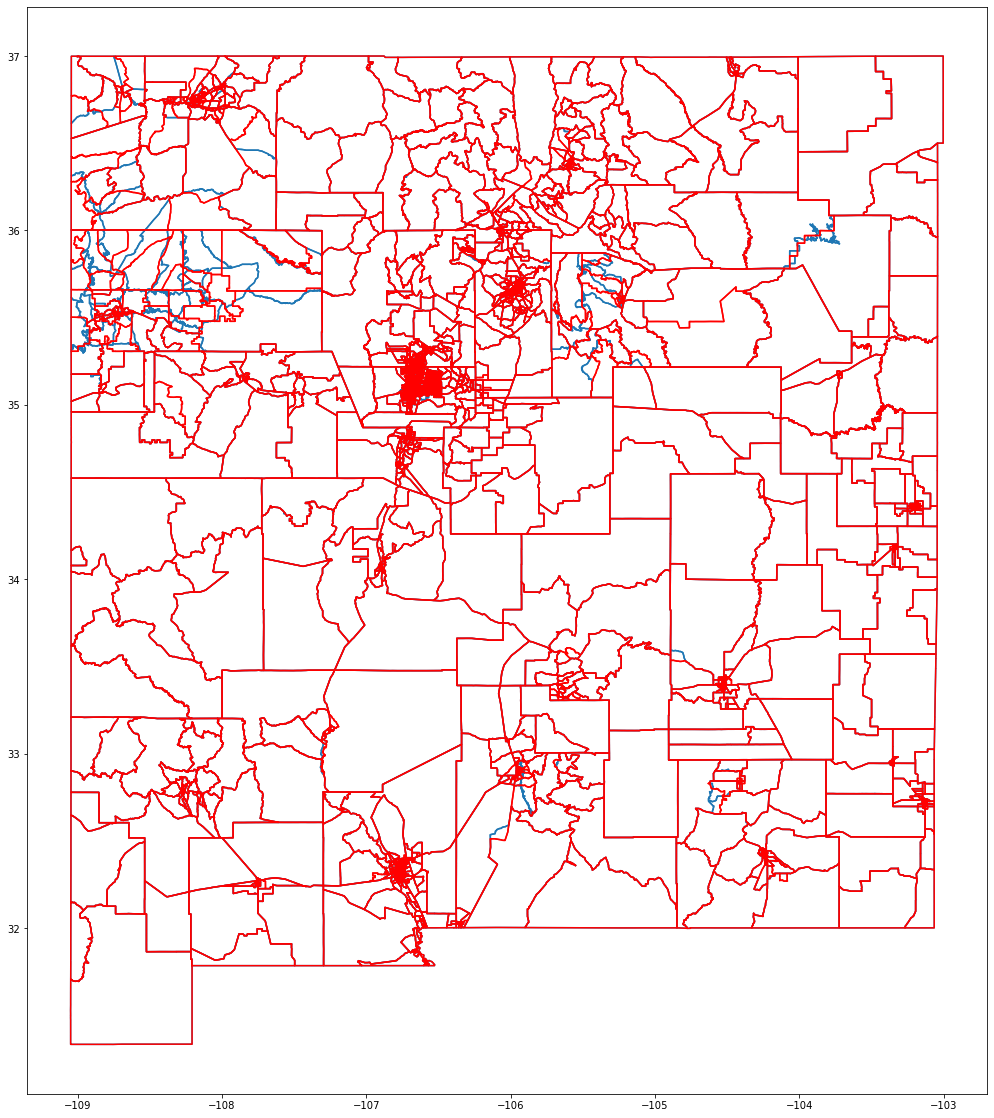

In [29]:
ax = vest_nm_20.boundary.plot(figsize=(20,20))
source_shapes.boundary.plot(ax = ax,color="red")

In [30]:
precincts_2012 = gp.read_file("./raw-from-source/Shapefile/precincts_2012/precincts_2012.shp")
precincts_2012 = precincts_2012.to_crs(vest_nm_20.crs)

<AxesSubplot:>

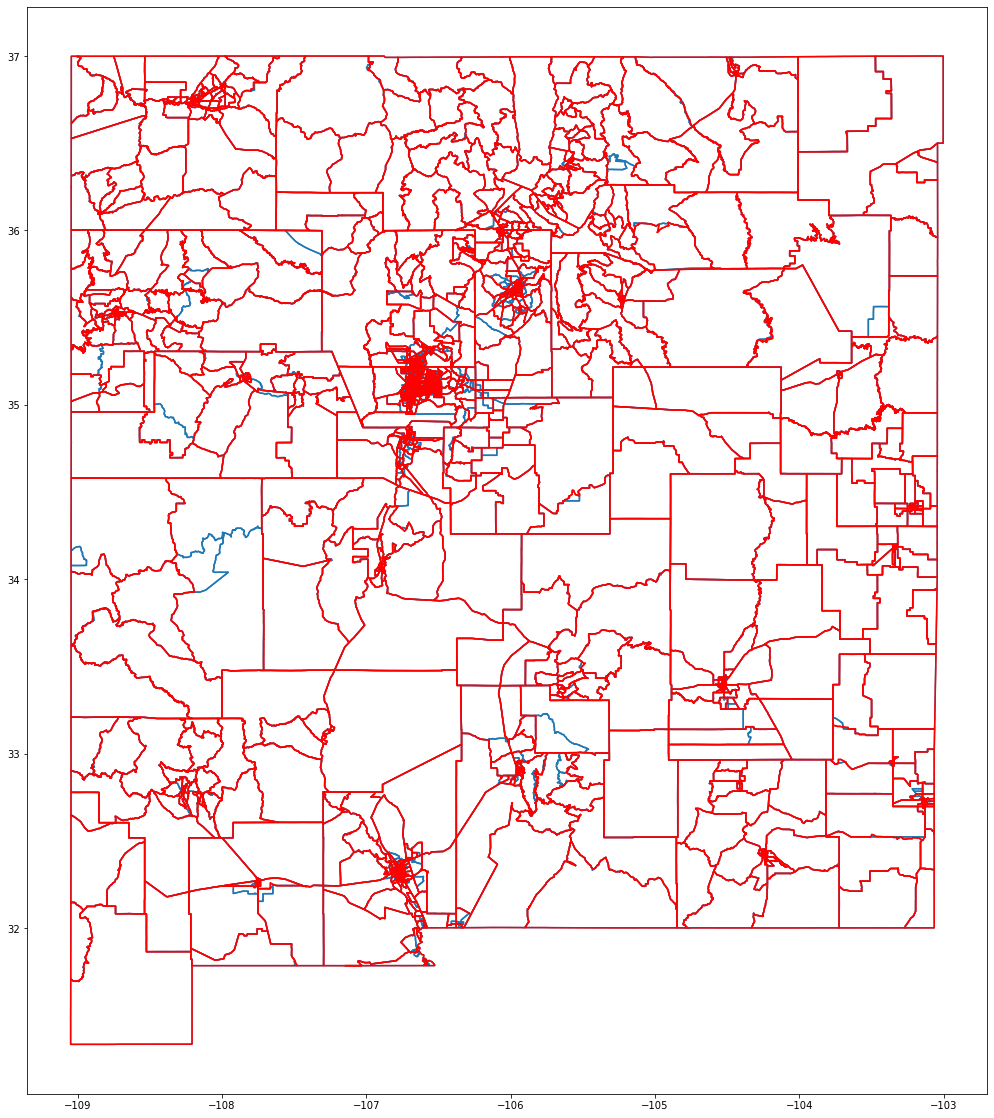

In [31]:
ax = vest_nm_20.boundary.plot(figsize=(20,20))
precincts_2012.boundary.plot(ax = ax,color="red")